# WISDM HAR

Class
- Walking, Jogging, Upstairs, Downstairs, Sitting, Standing

Sampling rate
- 20Hz

Fields
- user, activity, timestamp, x-acceleration, y-acceleration, z-acceleration



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import GRU, Conv1D, MaxPool1D, BatchNormalization, Dense, Input, ReLU, Dropout, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";") # comment: ';'로 시작하는 줄 무시(주석)


In [ ]:
data.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,NaN
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,NaN
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,NaN
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,NaN
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,NaN
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,NaN


In [ ]:
def convert_to_float(x):
    try:
        return np.float32(x)
    except:
        return np.nan

In [ ]:
df = data.drop('NaN', axis=1)
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,1


In [ ]:
df = df.dropna()
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,0


In [ ]:
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')

df["x_axis"] = df["x_axis"].apply(convert_to_float)
df["y_axis"] = df["y_axis"].apply(convert_to_float)
df["z_axis"] = df["z_axis"].apply(convert_to_float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float32
 4   y_axis     1098203 non-null  float32
 5   z_axis     1098203 non-null  float32
dtypes: float32(3), int64(2), object(1)
memory usage: 46.1+ MB


In [ ]:
df['activity'].value_counts()

,count
activity,
Walking,424397
Jogging,342176
Upstairs,122869
Downstairs,100427
Sitting,59939
Standing,48395


In [ ]:
df['user_id'].value_counts()

,count
user_id,
20,56632
19,45383
31,44282
8,41188
29,38245
14,38192
13,37093
34,35947
32,35506


In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
num_classes = len(label_encoder.classes_)

df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,activity_encoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [ ]:
# label_encoder 매핑 결과 보기
dict(enumerate(label_encoder.classes_))

{0: 'Downstairs',
 1: 'Jogging',
 2: 'Sitting',
 3: 'Standing',
 4: 'Upstairs',
 5: 'Walking'}

In [ ]:
# Data Split
df_train = df[df['user_id'] <= 26]
df_val   = df[(df['user_id'] > 26) & (df['user_id'] < 32)]
df_test = df[df['user_id'] >= 32]

In [ ]:
# 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.fit_transform(df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']])
# test 셋에서 train에서 학습한 scaler 사용
df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']])
df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']])

Segmentation
- 슬라이딩 윈도우 방식
- 데이터를 time_steps만큼 자르고 step 간격으로 이동
- 해당 구간에서 가장 많이 나타난 label을 출력값으로 저장
- 결과적으로 딥러닝 모델에 넣을 수 있는 3차원 입력 데이터와 라벨 벡터를 생성
- 3차원 입력 데이터: (샘플 수, 한 샘플이 가지는 시간 길이, feature 개수)

In [ ]:
def create_dataset(x, y, time_steps=200, step=40):
    xs, ys = [], []
    for i in range(0, len(x) - time_steps, step):
        v = x.iloc[i:i + time_steps].values
        labels = y.iloc[i:i + time_steps]
        values, counts = np.unique(labels, return_counts=True)
        mode_label = values[np.argmax(counts)]
        xs.append(v)
        ys.append(mode_label)
    return np.array(xs), np.array(ys)

TIME_STEPS = 200
STEP = 40
x_train, y_train = create_dataset(df_train[['x_axis', 'y_axis', 'z_axis']], df_train['activity_encoded'], TIME_STEPS, STEP)
x_val, y_val = create_dataset(df_val[['x_axis', 'y_axis', 'z_axis']], df_val['activity_encoded'], TIME_STEPS, STEP)
x_test, y_test = create_dataset(df_test[['x_axis', 'y_axis', 'z_axis']], df_test['activity_encoded'], TIME_STEPS, STEP)

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((19457, 200, 3), (19457,), (4100, 200, 3), (4100,), (3885, 200, 3), (3885,))

In [ ]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(weights))
print(class_weights_dict)

{0: np.float64(1.899726615895333), 1: np.float64(0.5175284604745186), 2: np.float64(3.272283888328288), 3: np.float64(4.244546247818499), 4: np.float64(1.4834553217444342), 5: np.float64(0.429912943567988)}


## Model 1
- CNN 3

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,414 (755.52 KB)

 Trainable params: 192,518 (752.02 KB)

 Non-trainable params: 896 (3.50 KB)

None


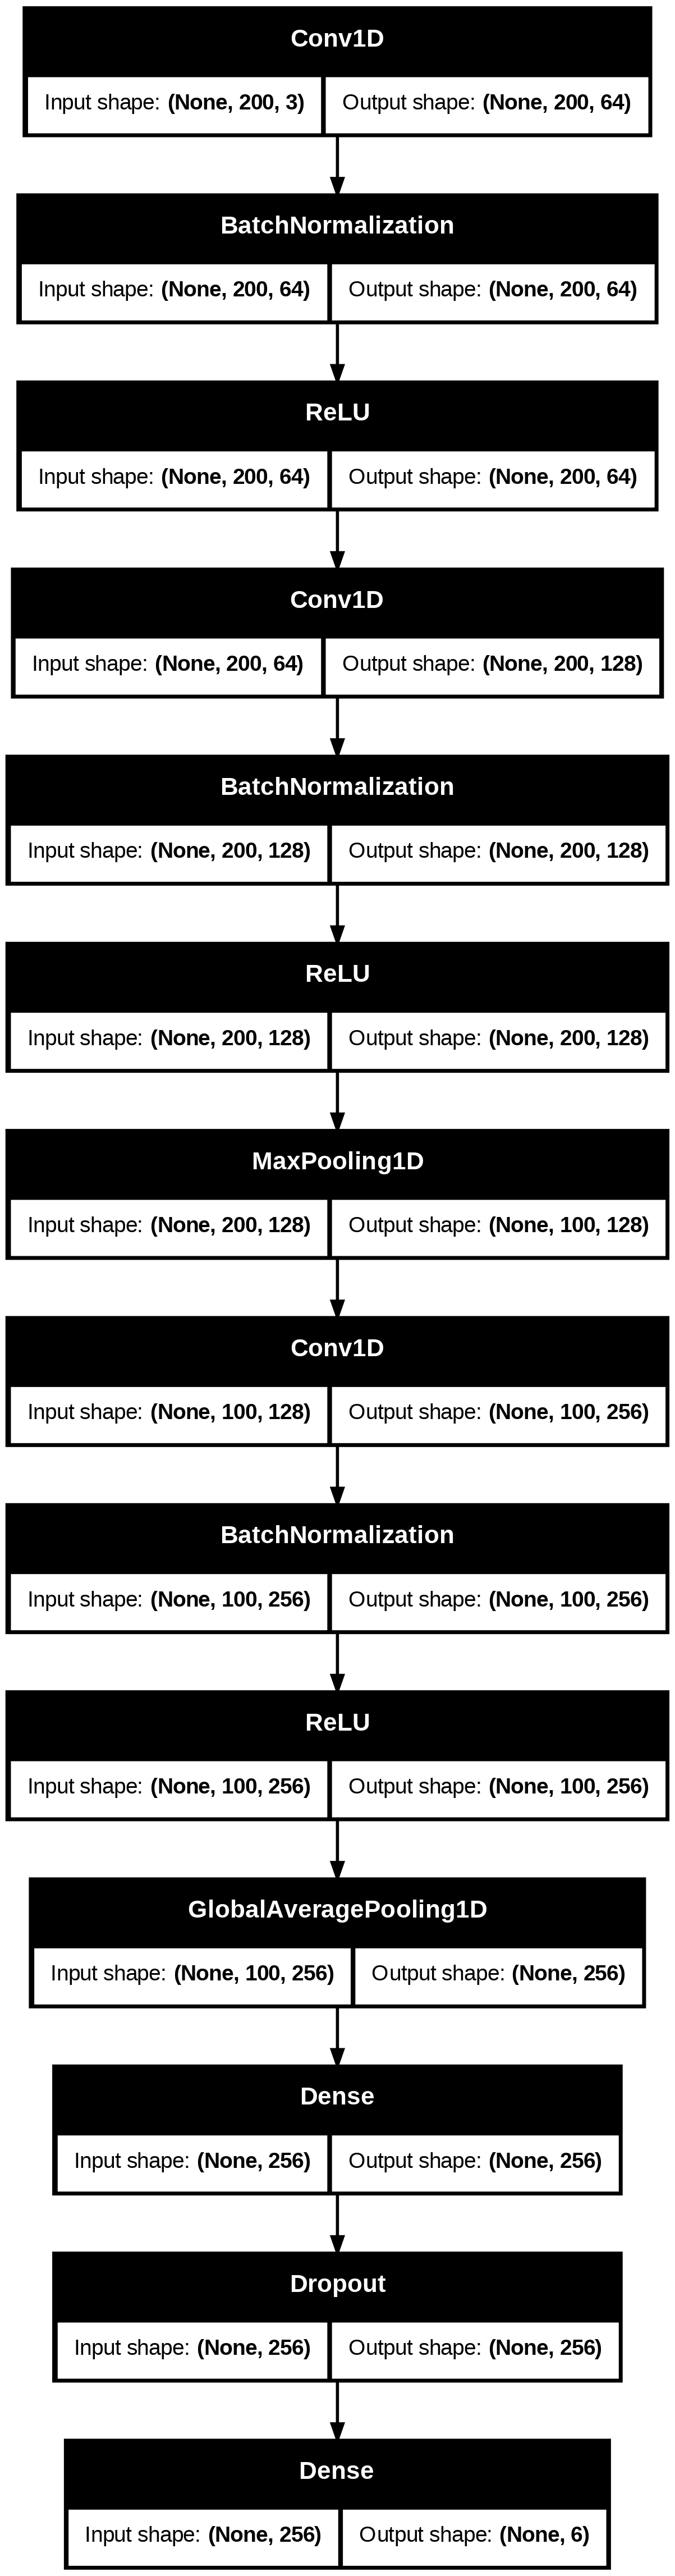

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_best.h5",
                save_best_only=True,
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4594 - sparse_categorical_accuracy: 0.8322
Epoch 1: val_loss improved from inf to 1.10410, saving model to WIDSM_HAR_CNN_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.4588 - sparse_categorical_accuracy: 0.8324 - val_loss: 1.1041 - val_sparse_categorical_accuracy: 0.6456
Epoch 2/100
299/305 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1403 - sparse_categorical_accuracy: 0.9507
Epoch 2: val_loss improved from 1.10410 to 0.85310, saving model to WIDSM_HAR_CNN_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1397 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.8531 - val_sparse_categorical_accuracy: 0.8080
Epoch 3/100
296/305 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9708
Epoch 3: val_loss did not improve from 0.85310
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0851 - sparse_categorical_accuracy: 0.9710 - val_loss: 1.2320 - val_sparse_categorical_accuracy: 0.6910
Epoch 4/100
300/305 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0835 - sparse_categorical_accuracy: 0.9699
Epoch 4: val_loss did not improve from 0.85310
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0833 - sparse_categorical_accuracy: 0.9700 - val_loss: 1.5844 - val_sparse_categorical_accuracy: 0.6754
Epoch 5/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0664 - sparse_categorical_accuracy: 0.9797
Epoch 5: val_loss did not improve from 0.85310
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0663 - sparse_categorical

305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.6267 - val_sparse_categorical_accuracy: 0.8722
Epoch 8/100
298/305 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9783
Epoch 8: val_loss did not improve from 0.62670
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0682 - sparse_categorical_accuracy: 0.9784 - val_loss: 1.4355 - val_sparse_categorical_accuracy: 0.7454
Epoch 9/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0583 - sparse_categorical_accuracy: 0.9804
Epoch 9: val_loss did not improve from 0.62670
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0583 - sparse_categorical_accuracy: 0.9804 - val_loss: 1.4718 - val_sparse_categorical_accuracy: 0.8234
Epoch 10/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9883
Epoch 10: val_loss did not improve from 0.62670
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0361 - sparse_categoric

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_CNN_best.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 99.24%
Training loss: 0.0232
Test accuracy: 92.82%
Test loss: 0.2722


In [ ]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7937    0.8006    0.7971       346
           1     0.9843    0.9506    0.9671      1316
           2     0.9933    0.9933    0.9933       300
           3     0.9239    0.9630    0.9430       189
           4     0.8231    0.7995    0.8111       384
           5     0.9254    0.9563    0.9406      1350

    accuracy                         0.9282      3885
   macro avg     0.9073    0.9105    0.9087      3885
weighted avg     0.9287    0.9282    0.9282      3885



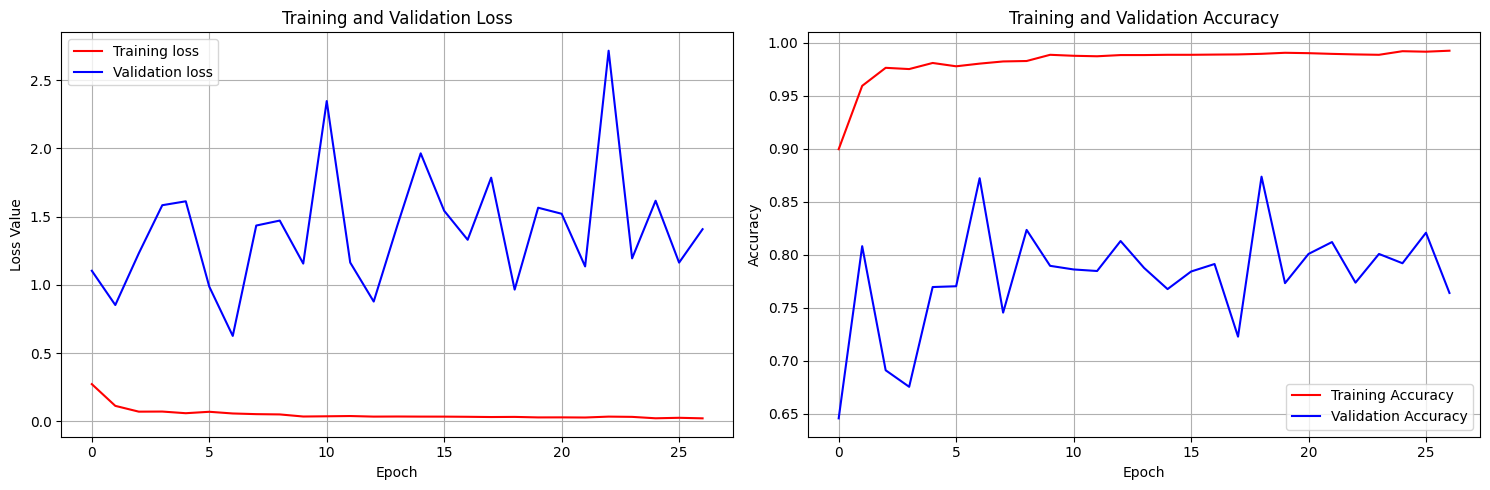

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

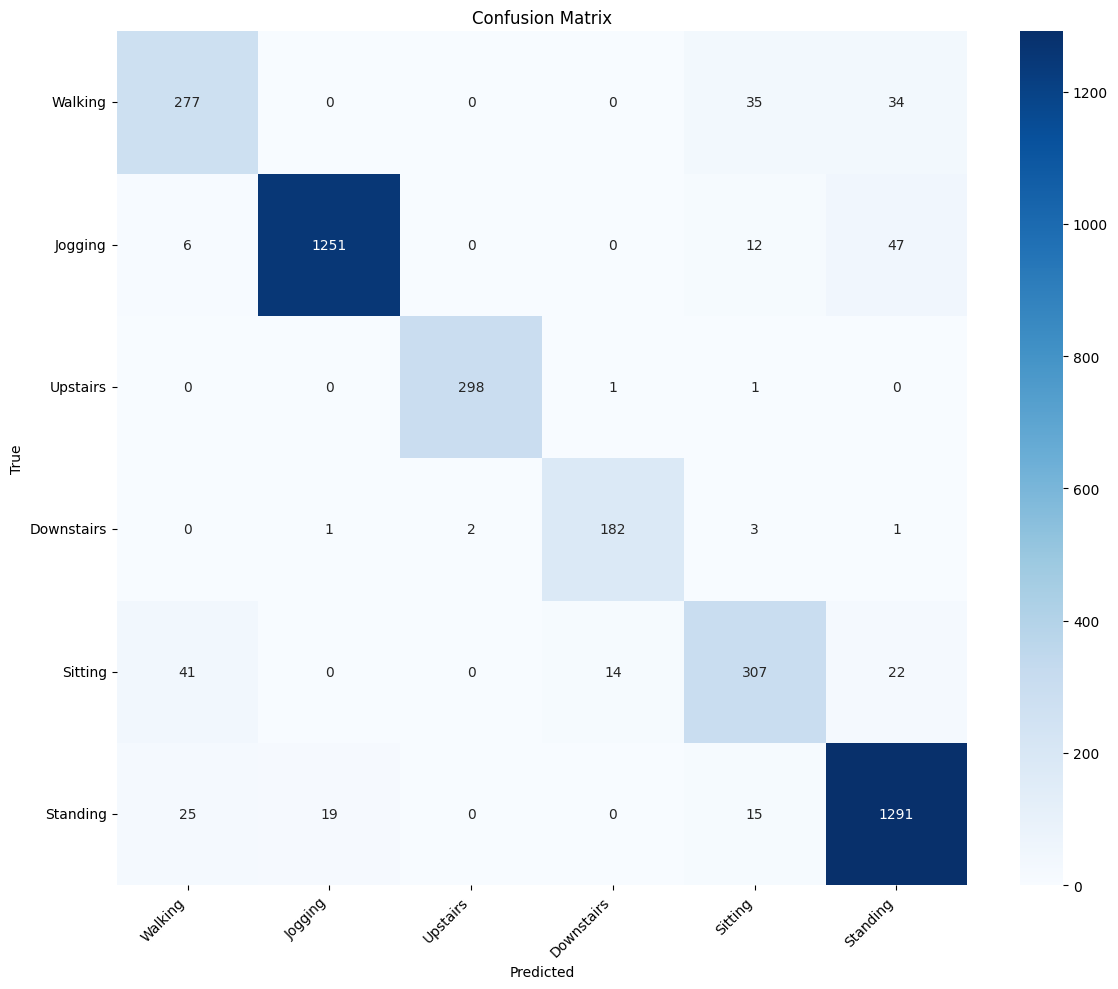

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 4

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(512, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 100, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,726 (2.50 MB)

 Trainable params: 652,806 (2.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


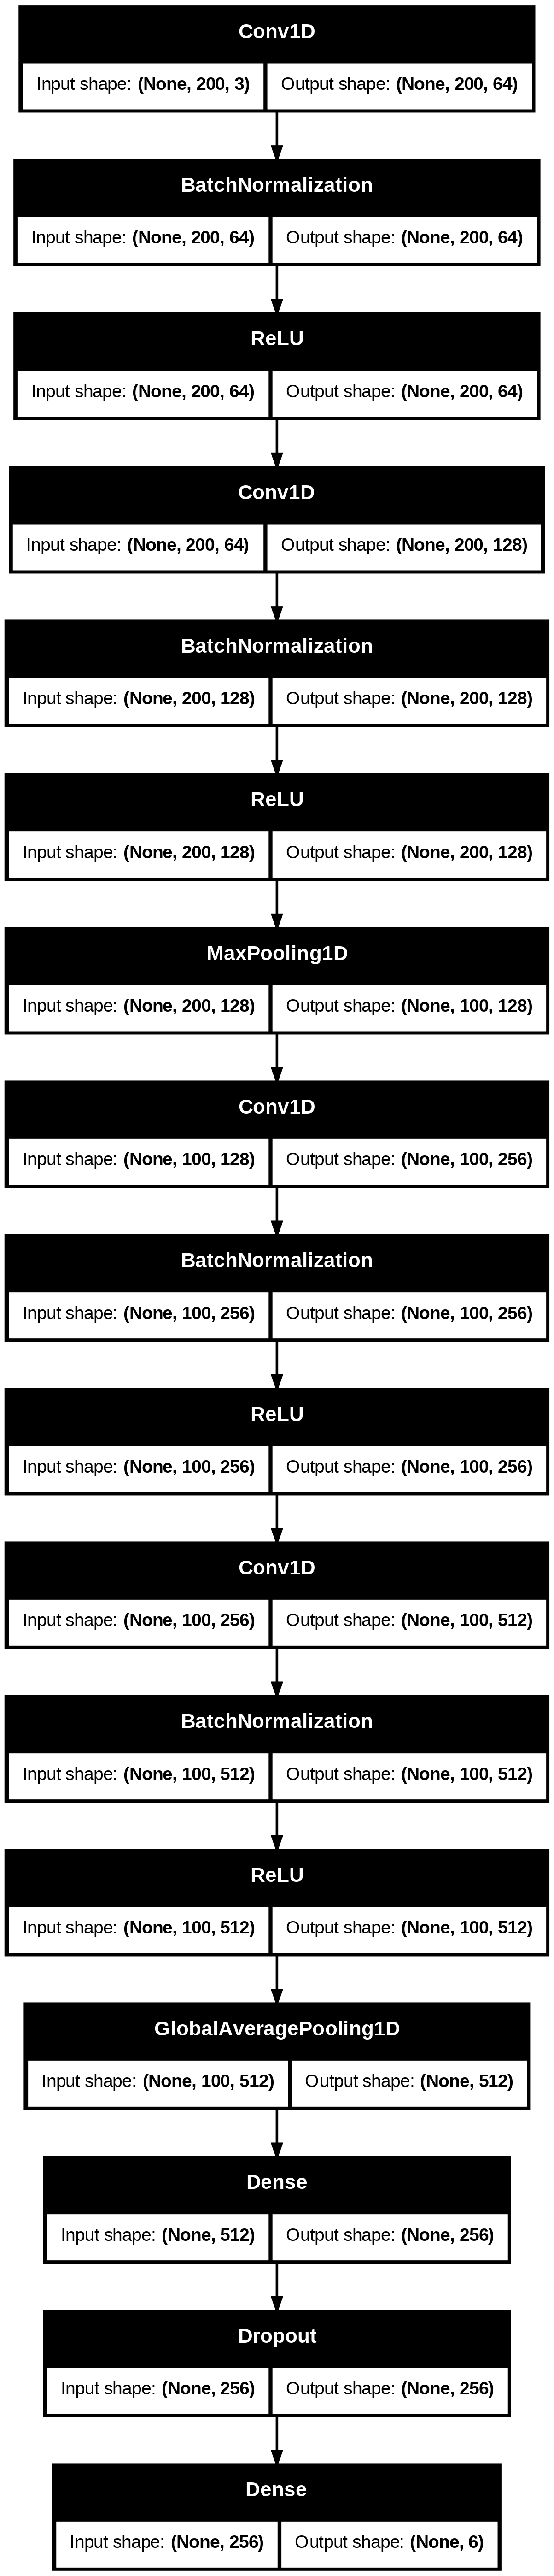

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_best2.h5",
                save_best_only=True,
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3800 - sparse_categorical_accuracy: 0.8614
Epoch 1: val_loss improved from inf to 0.88668, saving model to WIDSM_HAR_CNN_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.3795 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.8867 - val_sparse_categorical_accuracy: 0.8229
Epoch 2/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1157 - sparse_categorical_accuracy: 0.9601
Epoch 2: val_loss improved from 0.88668 to 0.56402, saving model to WIDSM_HAR_CNN_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1155 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.5640 - val_sparse_categorical_accuracy: 0.8593
Epoch 3/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9795
Epoch 3: val_loss did not improve from 0.56402
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9795 - val_loss: 1.3892 - val_sparse_categorical_accuracy: 0.7434
Epoch 4/100
302/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9811
Epoch 4: val_loss did not improve from 0.56402
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.8688
Epoch 5/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9840
Epoch 5: val_loss did not improve from 0.56402
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0473 - sparse_cate

305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0466 - sparse_categorical_accuracy: 0.9844 - val_loss: 0.5393 - val_sparse_categorical_accuracy: 0.8868
Epoch 7/100
300/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0627 - sparse_categorical_accuracy: 0.9819
Epoch 7: val_loss did not improve from 0.53927
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9819 - val_loss: 1.2821 - val_sparse_categorical_accuracy: 0.8144
Epoch 8/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9841
Epoch 8: val_loss did not improve from 0.53927
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9841 - val_loss: 1.1980 - val_sparse_categorical_accuracy: 0.8144
Epoch 9/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0449 - sparse_categorical_accuracy: 0.9872
Epoch 9: val_loss did not improve from 0.53927
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0450 - sparse_cate

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_CNN_best2.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 99.18%
Training loss: 0.0234
Test accuracy: 94.77%
Test loss: 0.2639


In [ ]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8249    0.8988    0.8603       346
           1     0.9976    0.9369    0.9663      1316
           2     0.9868    1.0000    0.9934       300
           3     1.0000    0.9841    0.9920       189
           4     0.8382    0.8229    0.8305       384
           5     0.9509    0.9896    0.9699      1350

    accuracy                         0.9477      3885
   macro avg     0.9331    0.9387    0.9354      3885
weighted avg     0.9495    0.9477    0.9480      3885



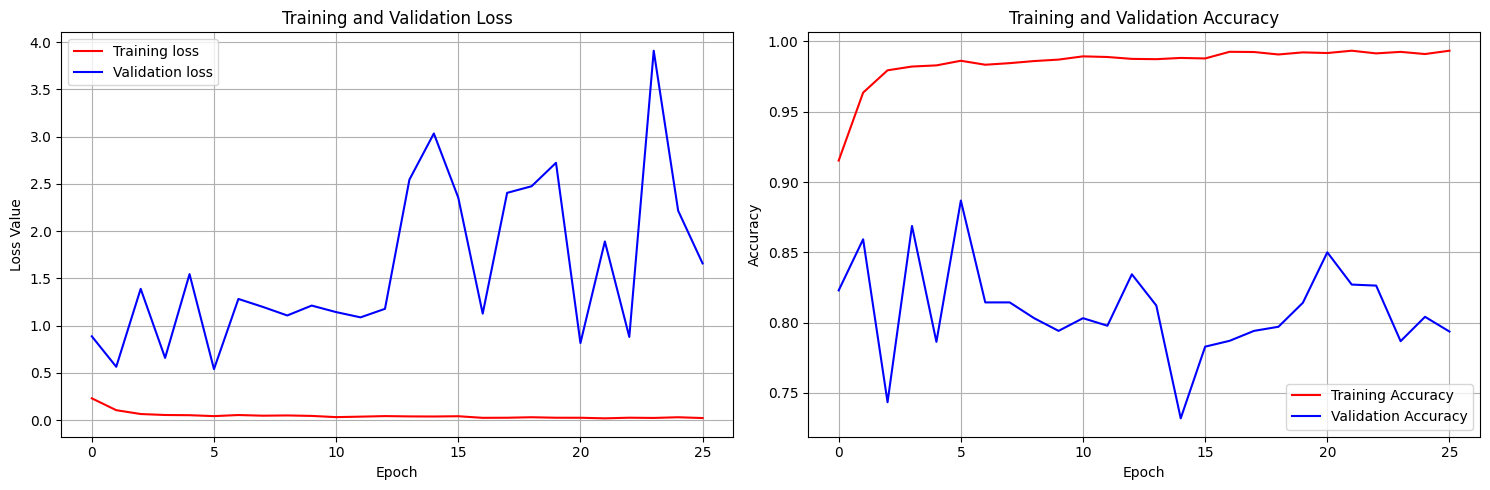

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

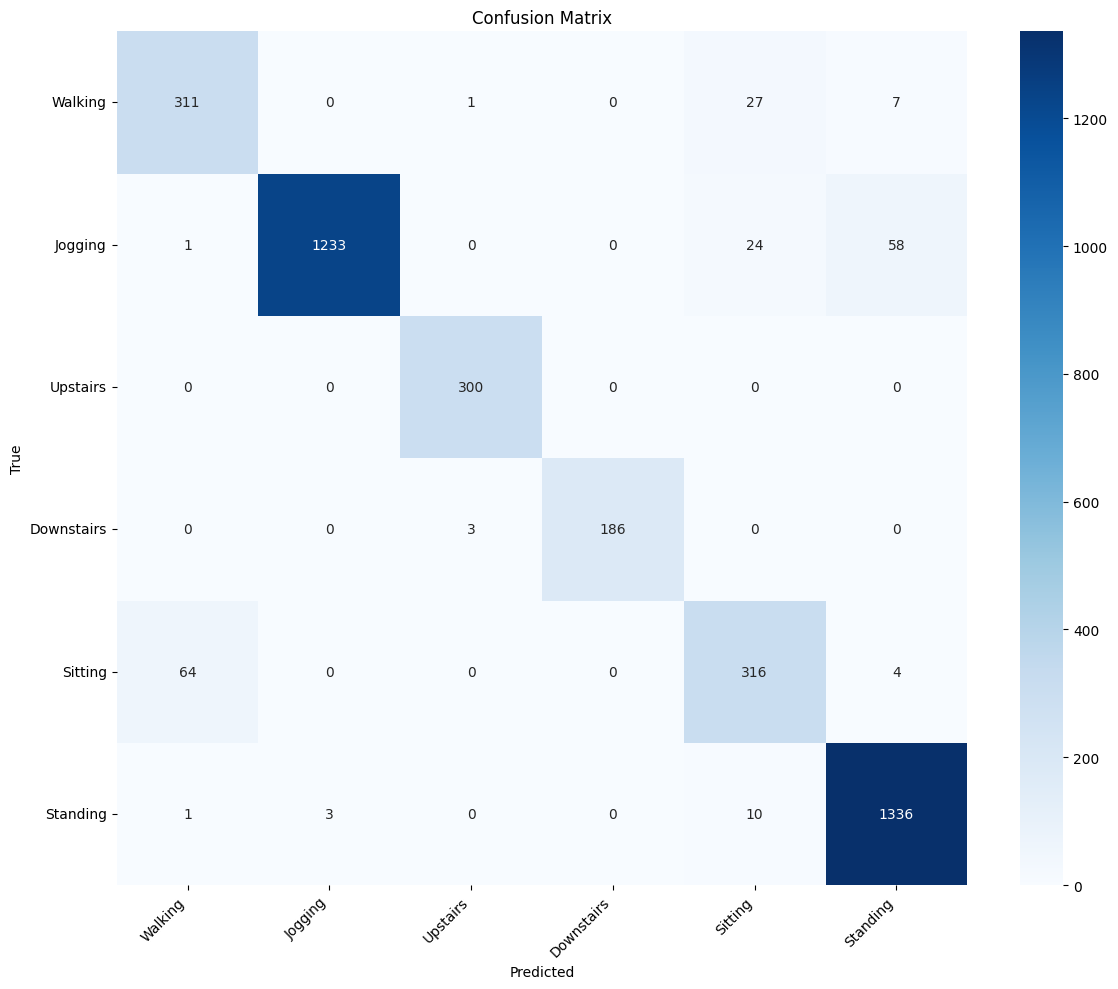

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()

## Model 3
- CNN 5

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(192, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(512, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 100, 192)       │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 100, 192)       │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 100, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 100, 256)       │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 50, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 50, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 50, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 778,566 (2.97 MB)

 Trainable params: 776,262 (2.96 MB)

 Non-trainable params: 2,304 (9.00 KB)

None


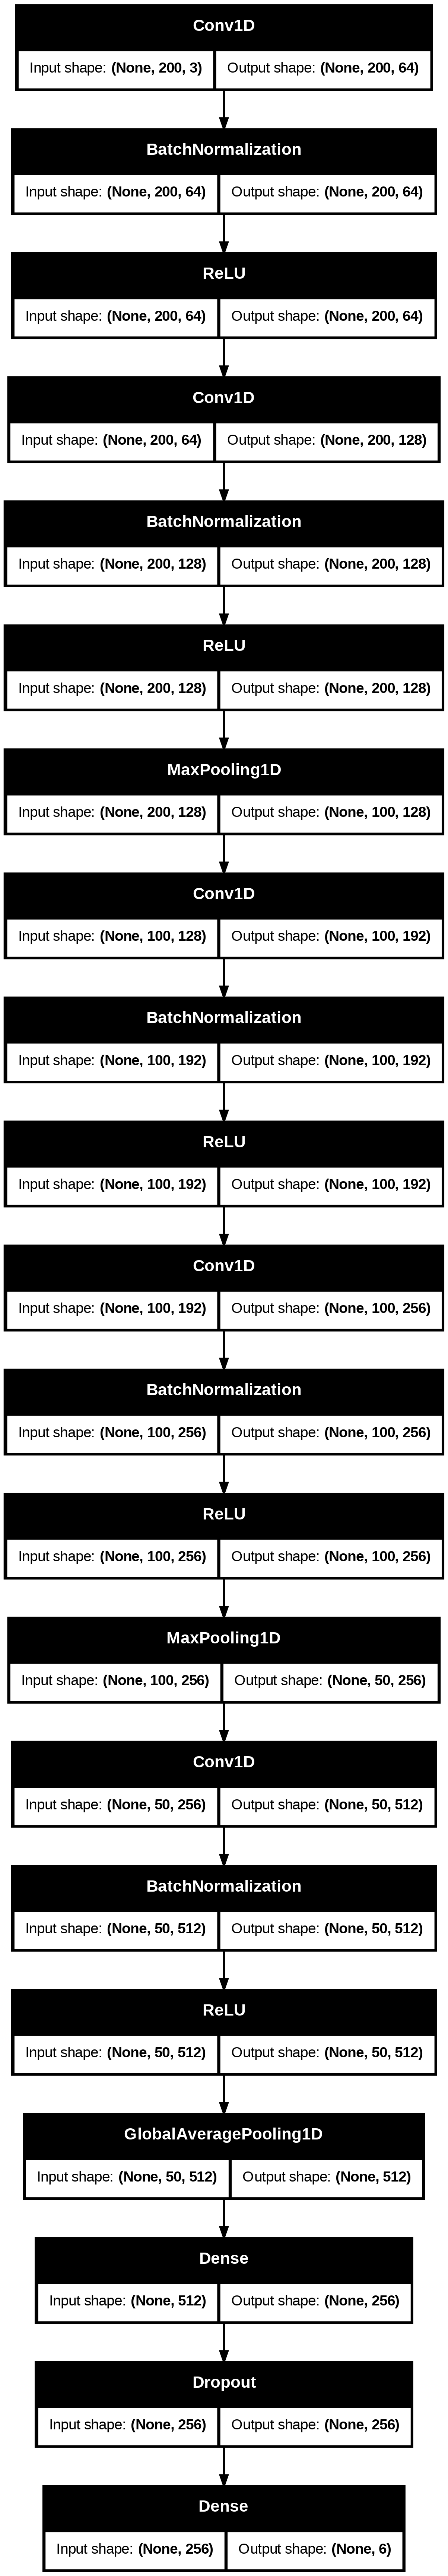

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_best3.h5",
                save_best_only=True,
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9949
Epoch 1: val_loss improved from inf to 1.33972, saving model to WIDSM_HAR_CNN_best3.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9949 - val_loss: 1.3397 - val_sparse_categorical_accuracy: 0.7900
Epoch 2/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0312 - sparse_categorical_accuracy: 0.9891
Epoch 2: val_loss did not improve from 1.33972
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0313 - sparse_categorical_accuracy: 0.9891 - val_loss: 1.4357 - val_sparse_categorical_accuracy: 0.8217
Epoch 3/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9903
Epoch 3: val_loss did not improve from 1.33972
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9904 - val_loss: 3.2824 - val_sparse_categorical_accuracy: 0.6876
Epoch 4/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9852
Epoch 4: val_loss did not improve from 1.33972
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0585 - sparse_cate

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.9230 - val_sparse_categorical_accuracy: 0.8149
Epoch 12/100
300/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9922
Epoch 12: val_loss did not improve from 0.92300
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9922 - val_loss: 1.1925 - val_sparse_categorical_accuracy: 0.8061
Epoch 13/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9932
Epoch 13: val_loss did not improve from 0.92300
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9932 - val_loss: 2.0575 - val_sparse_categorical_accuracy: 0.7646
Epoch 14/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9935
Epoch 14: val_loss did not improve from 0.92300
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0181 - spars

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_CNN_best3.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 99.70%
Training loss: 0.0082
Test accuracy: 95.16%
Test loss: 0.3561


In [ ]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8596    0.8844    0.8718       346
           1     0.9572    0.9696    0.9634      1316
           2     0.9967    0.9933    0.9950       300
           3     0.9843    0.9947    0.9895       189
           4     0.9136    0.8542    0.8829       384
           5     0.9659    0.9637    0.9648      1350

    accuracy                         0.9516      3885
   macro avg     0.9462    0.9433    0.9446      3885
weighted avg     0.9516    0.9516    0.9515      3885



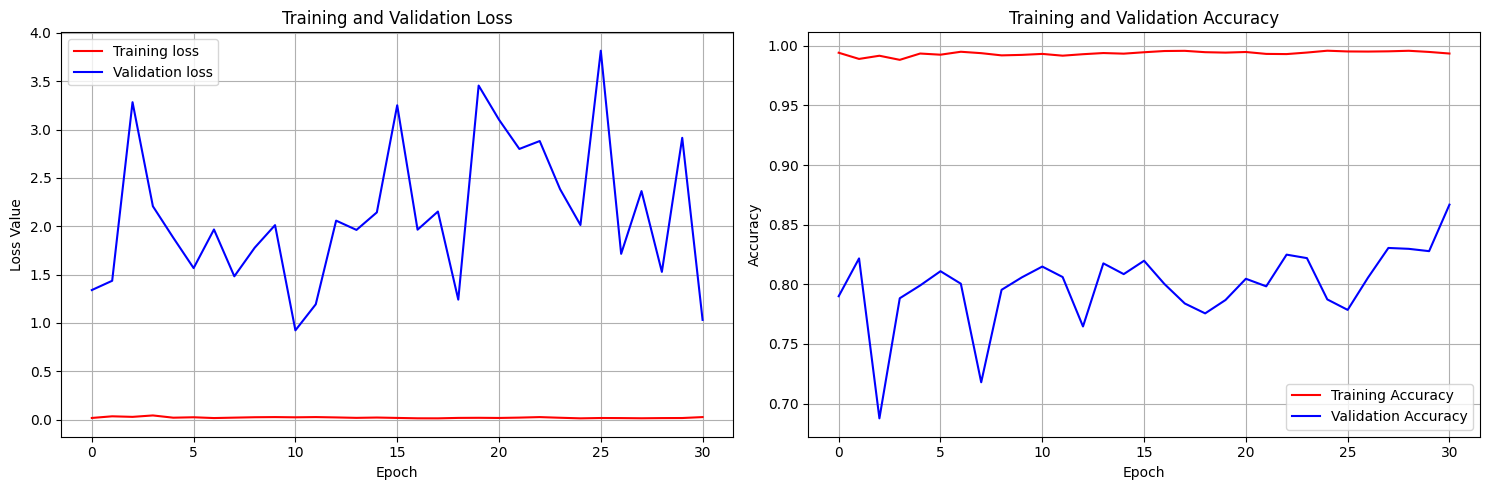

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

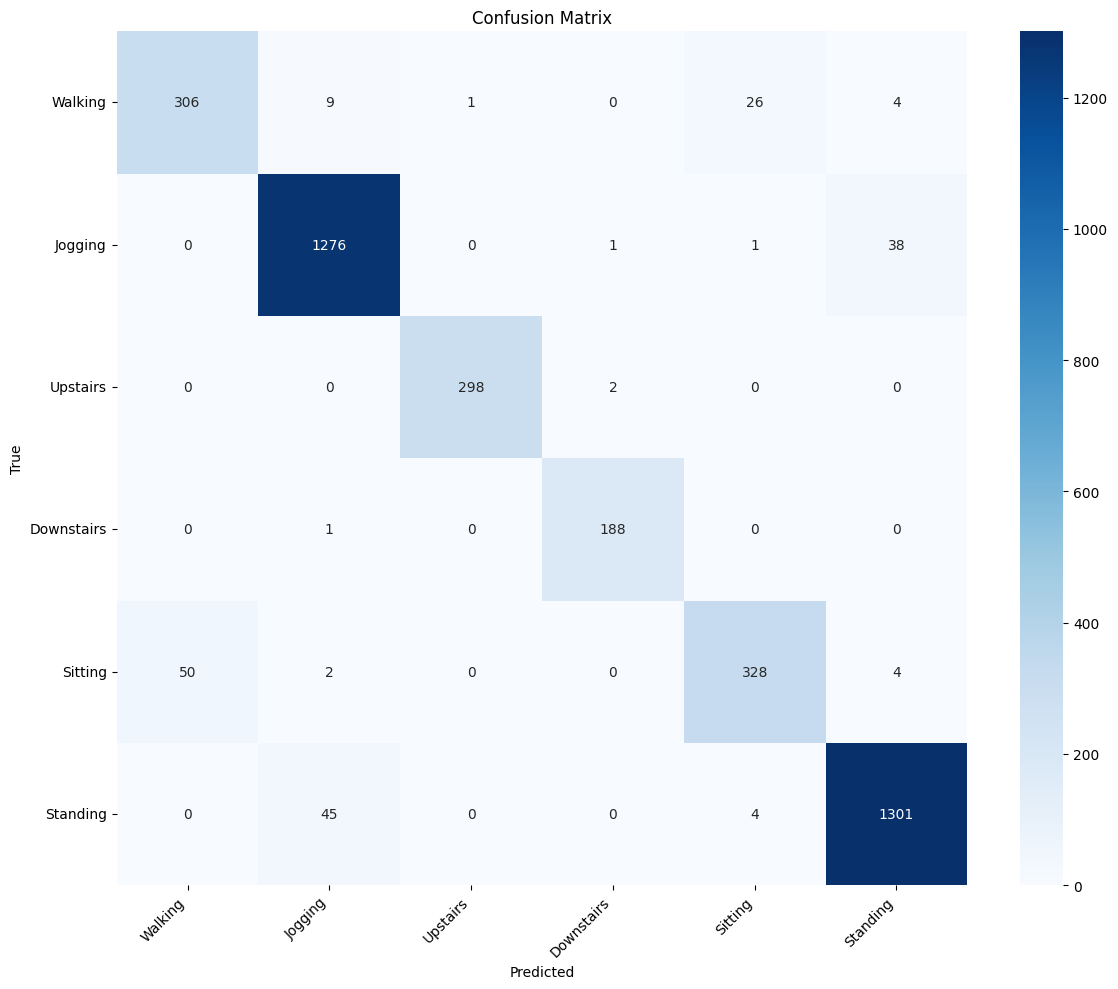

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()